In [2]:
import pandas as pd 
import numpy as np
import time as time

import matplotlib.pyplot as plt
import seaborn as sns

import pybaseball
from pybaseball import statcast 
from pybaseball.lahman import people

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import hyperopt.hp as hp
from hyperopt import fmin, tpe, Trials, STATUS_OK

import joblib



# Data Collection

In [3]:
year = 2023

data = statcast(start_dt= f"{year}-03-30",
                end_dt = f"{year}-09-30")

This is a large query, it may take a moment to complete


/Users/aidanbeilke/Desktop/Baseball Projects/.venv/lib/python3.11/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/185 [00:00<?, ?it/s]/Users/aidanbeilke/Desktop/Baseball Projects/.venv/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passin

In [4]:
data.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [5]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
3407,FF,2023-09-30,96.1,-2.08,5.57,"Smith, Drew",664761,622098,field_out,hit_into_play,...,11,4,11,Standard,Standard,212,0.0,-0.074,<NA>,<NA>
3614,FF,2023-09-30,96.5,-1.94,5.59,"Smith, Drew",664761,622098,NaN,foul,...,11,4,11,Standard,Standard,209,0.0,0.0,<NA>,<NA>
3766,SL,2023-09-30,86.6,-1.91,5.54,"Smith, Drew",664761,622098,NaN,ball,...,11,4,11,Standard,Standard,114,0.0,0.009,<NA>,<NA>
3859,SL,2023-09-30,87.1,-2.01,5.55,"Smith, Drew",664761,622098,NaN,swinging_strike,...,11,4,11,Standard,Standard,108,0.0,-0.023,<NA>,<NA>
4042,FF,2023-09-30,95.9,-2.1,5.51,"Smith, Drew",664761,622098,NaN,foul,...,11,4,11,Standard,Standard,215,0.0,-0.017,<NA>,<NA>


# EDA

In [6]:
pitch_data = data[['plate_x', 'plate_z', 'pitch_name']].dropna().sample(1000)

pitch_data

,plate_x,plate_z,pitch_name
3769,-1.12,2.09,Sweeper
90,-1.01,3.57,4-Seam Fastball
1052,0.46,0.69,Changeup
1929,0.11,1.87,Slider
324,-0.8,3.69,4-Seam Fastball
...,...,...,...
1085,0.32,3.33,Sweeper
2455,0.98,2.19,4-Seam Fastball
4072,-0.75,2.94,Sinker
1340,0.1,2.72,4-Seam Fastball


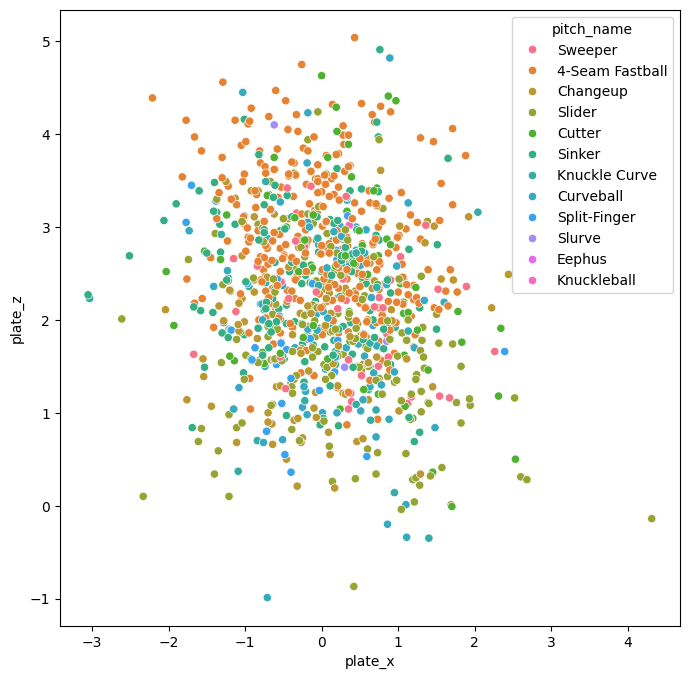

In [7]:
fig = plt.figure(figsize = (8,8))

fig = sns.scatterplot(data = pitch_data, x = 'plate_x', y = 'plate_z',
                      hue = 'pitch_name')
plt.show()

In [8]:
data['attack_zone'] = ""

data.loc[(data['plate_x'].between(-0.558, 0.558)) & (data['plate_z'].between(1.833, 3.166)), 'attack_zone'] = 'heart'
data.loc[(data['plate_x'].between(-1.100, 1.100)) & (data['plate_z'].between(1.166, 3.833)) & (~data['attack_zone'].isin(['heart'])), 'attack_zone'] = 'shadow'
data.loc[(data['plate_x'].between(-1.166, 1.666)) & (data['plate_z'].between(0.5, 4.5)) & (~data['attack_zone'].isin(['heart', 'shadow'])), 'attack_zone'] = 'chase'

data.loc[data['attack_zone'] == "", 'attack_zone'] = 'waste'


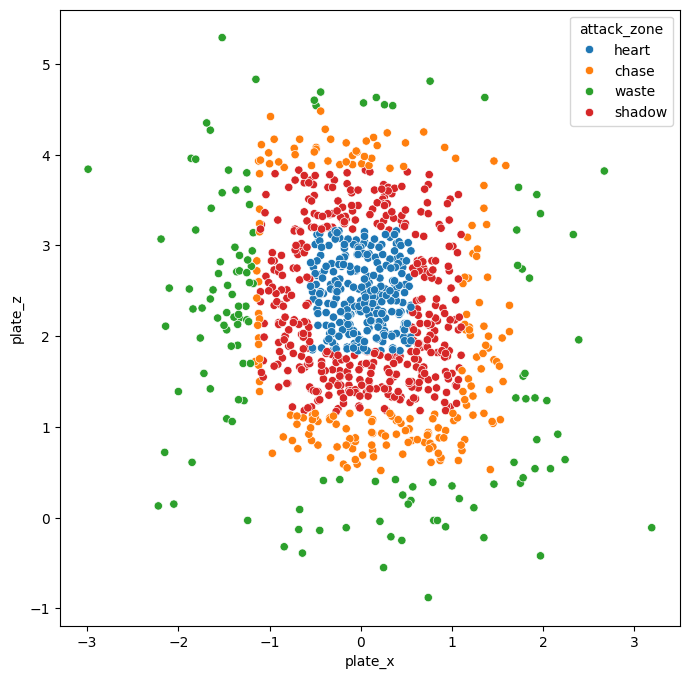

In [9]:
samp = data.sample(1000)

fig2 = plt.figure(figsize = (8,8))

fig2 = sns.scatterplot(data = samp,
                       x = 'plate_x',
                       y = 'plate_z',
                       hue = 'attack_zone')

plt.show()

In [10]:
data['description'].unique()

array(['hit_into_play', 'foul', 'ball', 'swinging_strike',
       'called_strike', 'foul_tip', 'blocked_ball', 'hit_by_pitch',
       'swinging_strike_blocked', 'foul_bunt', 'missed_bunt', 'pitchout',
       'bunt_foul_tip'], dtype=object)

In [11]:
swing = {
    'hit_into_play' : 'Y',
    'foul' : 'Y',
    'ball' : 'N',
    'swinging_strike': 'Y',
    'called_strike' : 'N',
    'foul_tip' : 'Y',
    'blocked_ball' : 'N',
    'hit_by_pitch' : 'N',
    'swinging_strike_blocked' : 'Y',
    'foul_bunt' : 'Y',
    'missed_bunt' : 'Y',
    'pitchout' : 'N',
    'bunt_foul_tip' : 'Y'
}

In [12]:
data['swing'] = data['description'].map(swing)

In [13]:
data[['description', 'attack_zone', 'swing', 'delta_run_exp']]



,description,attack_zone,swing,delta_run_exp
3407,hit_into_play,waste,Y,-0.074
3614,foul,heart,Y,0.0
3766,ball,chase,N,0.009
3859,swinging_strike,chase,Y,-0.023
4042,foul,shadow,Y,-0.017
...,...,...,...,...
3833,called_strike,shadow,N,-0.079
4044,called_strike,shadow,N,-0.078
4108,ball,chase,N,0.135
4358,ball,waste,N,0.064


In [14]:
df = (data.groupby(
    ['attack_zone', 'swing'])
    ['delta_run_exp']
    .mean()
    .mul(100)
    .reset_index(name='Run_exp/100'))

df = pd.DataFrame(df)

df


,attack_zone,swing,Run_exp/100
0,chase,N,5.683862
1,chase,Y,-8.337312
2,heart,N,-5.908055
3,heart,Y,0.951783
4,shadow,N,-0.012441
5,shadow,Y,-3.289347
6,waste,N,6.102158
7,waste,Y,-9.270391


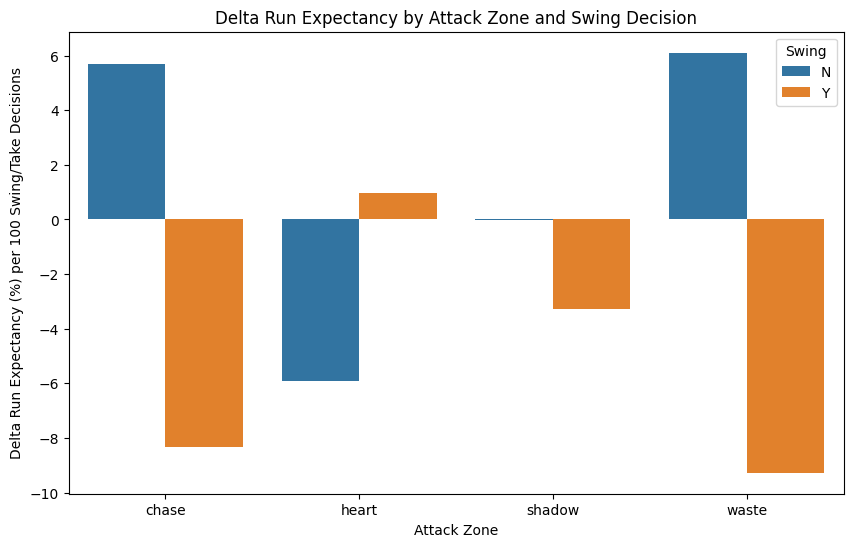

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='attack_zone', y='Run_exp/100', hue='swing')
plt.title('Delta Run Expectancy by Attack Zone and Swing Decision')
plt.xlabel('Attack Zone')
plt.ylabel('Delta Run Expectancy (%) per 100 Swing/Take Decisions')
plt.legend(title='Swing')
plt.show()

In [16]:
data = data.reset_index(drop=True)

data['delta_run_exp'].dtype


Float64Dtype()

In [17]:
data['delta_run_exp'].describe()

count    713498.0
mean     0.000069
std      0.244822
min        -1.359
25%        -0.065
50%        -0.017
75%         0.036
max         3.614
Name: delta_run_exp, dtype: Float64

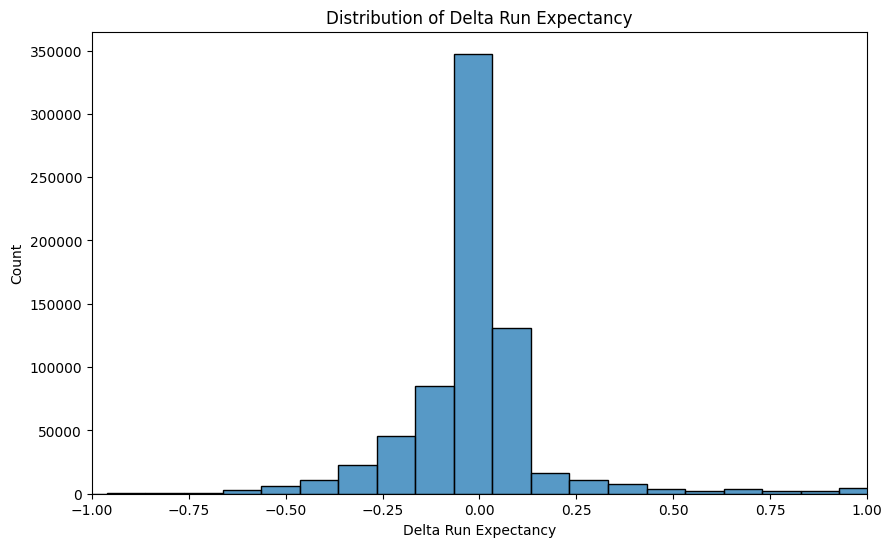

In [18]:
plt.figure(figsize = (10,6))

sns.histplot(data = data,
         x = 'delta_run_exp',
         bins = 50)

plt.xlim(-1, 1)
plt.xlabel('Delta Run Expectancy')
plt.title('Distribution of Delta Run Expectancy')


plt.show()

In [19]:
df_path = '/Users/aidanbeilke/Desktop/Baseball Projects/attack_df.csv'

data.to_csv(df_path)